## 6️⃣ ML Model Training
<!-- **designed by:** [datamover.ai](https://www.datamover.ai) -->

In [38]:
# Load libraries
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn import metrics
from time import time
from R6_Functions import chain_snap, encode_categorical_features 
from sklearn.ensemble import RandomForestRegressor #, GradientBoostingRegressor

# Set random seed
np.random.seed(42)

**1. Load the train and validation datasets used in section 4️⃣ Create a baseline Model and carry out data cleaning procedure based on the previous findings**

In [39]:
DATA_TRAIN_PATH = os.path.join("data", "data_train_processed.parquet")
DATA_VAL_PATH = os.path.join("data", "data_val_processed.parquet")

In [40]:
# Load the dataset processed in the previous
data_train = (
    pd.read_parquet(DATA_TRAIN_PATH)
    # double check missing values and duplicates
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="• Number of duplicate rows in train dataset",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="• Number of missing values in train dataset",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.shape[0],
        msg="• Number of samples (train dataset)",
    )
)

data_val = (
    pd.read_parquet(DATA_VAL_PATH)
    # double check missing values and duplicates
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="• Number of duplicate rows in validation dataset",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="• Number of missing values in validation dataset",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.shape[0],
        msg="• Number of samples(validation dataset)",
    )
)

# Consider the log of the price as the target variable
TARGET = "log(Price)"

display(data_train.head(2))
display(data_val.head(2))

• Number of duplicate rows in train dataset: 0
• Number of missing values in train dataset: 0
• Number of samples (train dataset): 552
• Number of duplicate rows in validation dataset: 0
• Number of missing values in validation dataset: 0
• Number of samples(validation dataset): 184


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078VH,81.0,3.0,4.894509,52.343016,13.36138,4.394449,1.098612,1078,0,7,8,VH,27.0,3.295837,3.317122,3.346089,0.031533
1,400000.0,"Jan van Riebeekstraat 3 1, Amsterdam",1057ZW,61.0,2.0,4.858697,52.370661,12.89922,4.110874,0.693147,1057,0,5,7,ZW,30.5,3.417727,1.947822,2.348155,0.036792


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000.0,"Lamarckhof 11 I, Amsterdam",1098TK,68,3,4.944251,52.352317,12.959844,4.219508,1.098612,1098,0,9,8,TK,22.666667,3.120895,3.606198,4.174069,0.071974
1,285000.0,"Kikkenstein 3534, Amsterdam",1104TT,96,4,4.972596,52.317512,12.560244,4.564348,1.386294,1104,1,0,4,TT,24.000000,3.178054,7.350449,8.209335,0.135124


In [41]:
# Split data in features and target
X_train, y_train = data_train.drop(TARGET, axis=1), data_train[TARGET]
X_val, y_val = data_val.drop(TARGET, axis=1), data_val[TARGET]

In [42]:
# Remove variables that are highly correlated to those before log transformation
X_train = X_train.select_dtypes(exclude= ["object","category"]) 
X_train = X_train.drop(['Price','Area', 'Room','AR-ratio'], axis=1) 

X_val = X_val.select_dtypes(exclude= ["object","category"])
X_val = X_val.drop(['Price','Area', 'Room','AR-ratio'], axis=1)


In [43]:
# Collect quantitative and categorical features
quantitative_features = [
    "log(Area)",
    "log(Room)",
    "log(AR-ratio)",
    "Euclidean_distance",
    "Haversine_distance",
    "Manhattan_distance",
]

categorical_features = ["Region", "Location", "District"]
X_train[categorical_features] = X_train[categorical_features].astype("category")
X_val[categorical_features] = X_val[categorical_features].astype("category")
# consider only quantitative features
X_train_num, X_val_num = X_train[quantitative_features], X_val[quantitative_features]

# apply one-hot encoding to categorical features
X_train_cat, X_val_cat = encode_categorical_features(
    X_train, X_val, categorical_features
)

# combine numerical and categorical features
X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_enc = pd.concat([X_val_num, X_val_cat], axis=1)

**2. Discard or fill in missing values using [imputation techniques](https://www.kaggle.com/code/residentmario/simple-techniques-for-missing-data-imputation), e.g., using the median value**

🙋‍♀️ scikit-learn will raise an error during training if the data contains Nan values;

- Small proportion of missing data (0.03%) has dropped previously, therefore no need to proceed this step. 

In [44]:
if len(data_train)==len(data_train.dropna()):
    print('• No missing values in train dataset')

if len(data_val)==len(data_val.dropna()):
    print('• No missing values in validation dataset')


• No missing values in train dataset
• No missing values in validation dataset


**3. Select a [cross-validation schema](https://scikit-learn.org/stable/modules/cross_validation.html) and an [evaluation metric](https://scikit-learn.org/stable/modules/model_evaluation.html) to be used for the hyperparameter tuning**

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define a function that compares the CV performance of a set of pre-determined models 
def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    explained_variance_cv=[]
    r2_cv = [] 
    mae_cv = []
    rmse_cv = []
    max_error_cv = []
    accuracy_cv = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of 
    # all CVs to the list
    for model in models:
        explained_variance = np.round(cross_val_score(model, X, y, scoring='explained_variance', cv=10), 4)
        explained_variance_cv.append(explained_variance)
        explained_variance_avg = round(explained_variance.mean(), 4)
        
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=10), 4)
        r2_cv.append(r2)
        r2_avg = round(r2.mean(), 4)
        
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=10), 4)
        mae_cv.append(mae)
        mae_avg = round(mae.mean(), 4)
        
        rmse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10), 4)
        rmse_cv.append(rmse)
        rmse_avg = round(rmse.mean(), 4)
        
        max_error = -np.round(cross_val_score(model, X, y, scoring='max_error', cv=10),4)
        max_error_cv.append(max_error)
        max_error_avg = round(max_error.mean(), 4)        
        accuracy = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accuracy_cv.append(accuracy)
        accuracy_avg = round(accuracy.mean(), 4)
        
        cv_accuracies[str(model)] = [explained_variance_avg, r2_avg,mae_avg, rmse_avg,max_error_avg, accuracy_avg]
    
        cv_accuracies.index = ['Explained Variance','R^2','Mean Absolute Error', 'Mean Squared Error', 'Max Error','Accuracy']
    
    return cv_accuracies,explained_variance_cv, r2_cv, mae_cv, rmse_cv,max_error_cv, accuracy_cv



In [46]:
# perform cross-validation on the training set
from sklearn.linear_model import LinearRegression, Ridge,Lasso, ElasticNet

# Create the models to be tested
model = [
    LinearRegression()
]

#display evaluation metrics for the models
comp, explained_variance_cv,r2_cv, mae_cv, rmse_cv, max_error_cv, accuracy_cv = cv_comparison(model, X_train_enc, y_train, 5)
display(comp.transpose())



# Create DataFrame for all RMSEs
rmse_comp = pd.DataFrame(rmse_cv, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', 
                                                           '4th Fold','5th Fold', '6th Fold',
                                                           '7th Fold','8th Fold','9th Fold','10th Fold'])

# Add a column for the averages
rmse_comp['Average'] = np.round(rmse_comp.mean(axis=1),4)

display(rmse_comp)



,Explained Variance,R^2,Mean Absolute Error,Mean Squared Error,Max Error,Accuracy
LinearRegression(),0.8615,0.8598,0.1421,0.0386,0.6892,98.9188


,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold,6th Fold,7th Fold,8th Fold,9th Fold,10th Fold,Average
LinearRegression(),0.0392,0.0622,0.0362,0.0415,0.0323,0.0251,0.0427,0.0414,0.0195,0.0454,0.0386


- When including all features, we observe high R^2, which is likely due to model overfitting and the presence of multicollinear features 
- Performed cross validation and evaluated on RMSE, which can be also observed high variance across different folds, indicating OLS model may overfit the target variables

**4. Select features that have shown a reasonable predictive power with the target variable**	

💁‍♂️ You can further reduce the number of features by applying [feature selection techniques](https://neptune.ai/blog/feature-selection-methods), such as wrapper and embedded methods.

#### A. Filter methods:

- I first combined the mutual information method and selectkbest methods for feature selection. The former calculates the mutual information between each feature of 𝑋 and the target variable 𝑌 independent of the remaining features of 𝑋; whereas the latter considers feature selection based on importance weights in linear regression model 
- As can be seen in the results, `log(Area)` has the highest mutual information gain (0.603), following by `log(Room)`,  location related variable `Euclidean_distance` and `log(AR-ratio)`

log(Area): 0.597
log(Room): 0.266
log(AR-ratio): 0.164
Euclidean_distance: 0.173
Haversine_distance: 0.126
Manhattan_distance: 0.163
Region_1: 0.07
Location_1: 0.046
Location_2: 0.007
Location_3: 0.011
Location_5: 0.019
Location_6: 0.028
Location_7: 0.039
Location_8: 0.013
Location_9: 0.0
District_1: 0.006
District_2: 0.0
District_3: 0.0
District_4: 0.015
District_5: 0.0
District_6: 0.0
District_7: 0.004
District_8: 0.0
District_9: 0.0


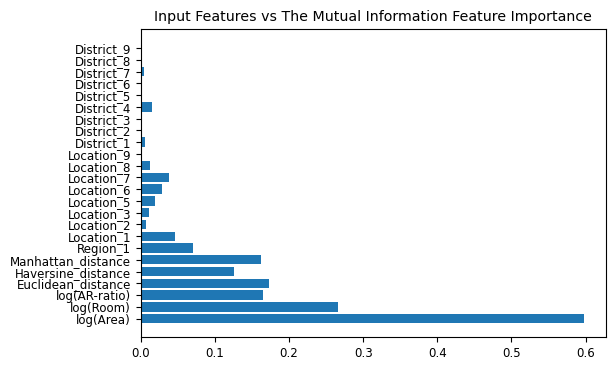

In [47]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
import matplotlib.pyplot as plt
# configure to select all features
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(X_train_enc, y_train)
# transform train input data
X_train_fs = fs.transform(X_train_enc)
# transform test input data
X_val_fs = fs.transform(X_val_enc)

# compute mutual information scores for all features
for i in range(len(fs.scores_)):
    print(f'{X_train_enc.columns[fs.get_support(indices=True)][i]}: {round(fs.scores_[fs.get_support()][i],3)}')
    

# visualise mutual information scores
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams.update({'font.size': 8.5})
plt.barh(X_train_enc.columns[fs.get_support(indices=True)], fs.scores_[fs.get_support()])
plt.title("Input Features vs The Mutual Information Feature Importance")
plt.show() 

In [48]:
# compare different numbers of features selected using mutual information
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# define the evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs),
                           ('lr', model)])

# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(X_train_enc.shape[1]-20, X_train_enc.shape[1]+1)]

# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X_train_enc, y_train)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# Results summary for different numbers of features
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param)) #summarised result indicated that the best number of features is 18

Best MAE: -0.039
Best Config: {'sel__k': 23}
>-0.054 with: {'sel__k': 4}
>-0.054 with: {'sel__k': 5}
>-0.054 with: {'sel__k': 6}
>-0.054 with: {'sel__k': 7}
>-0.053 with: {'sel__k': 8}
>-0.050 with: {'sel__k': 9}
>-0.046 with: {'sel__k': 10}
>-0.045 with: {'sel__k': 11}
>-0.043 with: {'sel__k': 12}
>-0.042 with: {'sel__k': 13}
>-0.042 with: {'sel__k': 14}
>-0.041 with: {'sel__k': 15}
>-0.041 with: {'sel__k': 16}
>-0.039 with: {'sel__k': 17}
>-0.039 with: {'sel__k': 18}
>-0.039 with: {'sel__k': 19}
>-0.039 with: {'sel__k': 20}
>-0.039 with: {'sel__k': 21}
>-0.039 with: {'sel__k': 22}
>-0.039 with: {'sel__k': 23}
>-0.039 with: {'sel__k': 24}


- Similarly, using F-regression also indicated `log(Area)` as the most relevant feature that is positively correlated to target.  Similarly, `log(Room)`, `log(AR-ratio)`, `Manhattan_distance` and several `location` related variables seems highly correlated with target 

log(Area): 887.244
log(Room): 262.788
log(AR-ratio): 179.943
Euclidean_distance: 78.186
Haversine_distance: 82.353
Manhattan_distance: 87.763
Region_1: 55.079
Location_1: 60.048
Location_2: 1.452
Location_3: 0.5
Location_5: 0.995
Location_6: 33.524
Location_7: 30.383
Location_8: 0.266
Location_9: 0.047
District_1: 4.672
District_2: 2.064
District_3: 2.447
District_4: 3.93
District_5: 0.262
District_6: 0.497
District_7: 8.636
District_8: 0.71
District_9: 0.05


Text(0.5, 1.0, 'Input Features vs ranked F-score Feature Importance')

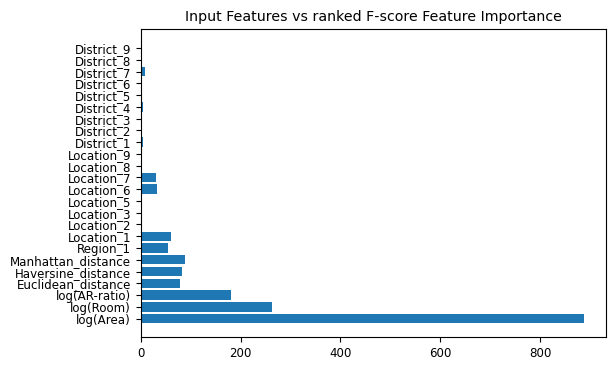

In [49]:
from sklearn.feature_selection import f_regression, SelectKBest
import matplotlib.pyplot as plt
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train_enc, y_train)
# transform train input data
X_train_fs = fs.transform(X_train_enc)
# transform test input data
X_val_fs = fs.transform(X_val_enc)

# return scores for the features
for i in range(len(fs.scores_)):
    print(f'{X_train_enc.columns[fs.get_support(indices=True)][i]}: {round(fs.scores_[fs.get_support()][i],3)}')
 
# plot the scores
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams.update({'font.size': 8.5})
plt.barh(X_train_enc.columns[fs.get_support(indices=True)], fs.scores_[fs.get_support()])
plt.title("Input Features vs ranked F-score Feature Importance")

- Lastly, using VarianceThreshold to remove features with low variance (i.e., removing those features with variance less than 1), returned features are quite similar to the results from f- regression (i.e., univariate linear regression based on F-test)


In [50]:
# Using VarianceThreshold to remove features with low variance, returned results indicated those features having greater than 1 variance
from sklearn.feature_selection import VarianceThreshold
X_train_number = X_train_enc.select_dtypes(include='number')
var_thr = VarianceThreshold(threshold=1)
_ = var_thr.fit_transform(X_train_number)

concol = [column for column in X_train_number.columns 
          if column not in X_train_number.columns[var_thr.get_support()]]

for features in concol:
    print(features)

log(Area)
log(Room)
log(AR-ratio)
Manhattan_distance
Region_1
Location_1
Location_2
Location_3
Location_5
Location_6
Location_7
Location_8
Location_9
District_1
District_2
District_3
District_4
District_5
District_6
District_7
District_8
District_9


##### B. Wrapper methods:

- Next, I used wrapper method for feature selection:

    - Recursive feature elimination (REF), a wrapper method, which returns features based on feature ranking with recursive feature elimination. The method itself utilises external estimator that assigns weights to the features. First, the estimator is trained on all features and each feature's importance is obtained through coeff_ or feature_importances_attribute. The least important feature is removed and this procedure is repeated until the desired number of features are selected.
    - Selected features showed similarly compared to filter methods. 


In [51]:
# Method B: Adopting the wrapper method for feature selection
from sklearn.feature_selection import RFE
svc = SVR(kernel="linear")
rfe = RFE(svc, n_features_to_select=10)
rfe.fit(X_train_enc, y_train)
X_selection_train = rfe.transform(X_train_enc)
#returning the best performing features:
X_train_wrapper = X_train_enc.columns[rfe.support_].tolist()
#returning the best performing features across train and validation dataset:
print(f"• RFE wrapper method suggested the best features are: {str(X_train_wrapper)[1:-1]}")

• RFE wrapper method suggested the best features are: 'log(Area)', 'log(Room)', 'log(AR-ratio)', 'Region_1', 'Location_1', 'Location_5', 'Location_6', 'Location_7', 'Location_9', 'District_9'


##### C.Embedded method 

In [74]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
# Define "menu" of regressors:
X=X_train_enc

# For LassoCV, first need to standardise the data, making coefficients comparable
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

_ = pipe.fit(X_train_enc, y_train)

# Scale regressors
X_train_scaled = pipe.fit_transform(X_train_enc)
X_val_scaled = pipe.fit_transform(X_val_enc)

# instantiate and fit our lassocv object #automatically choose alpha for you
lassocv=linear_model.LassoCV(random_state=42).fit(X_train_scaled,y_train)

# print out the chosen value for alpha
print("Chosen alpha: {:.4f}".format(lassocv.alpha_))

# print the original number of regressors and the number selected by lasso
print("Number of regressors in the menu: ",len(X.columns))
print("Number of regressors selected by lasso: ",sum(lassocv.coef_!=0)) #except those non-zero coeff lasso would through away, how much retained

# print out accuracy on training and test test
print("Accuracy on training set: {:.3f}".format(lassocv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(lassocv.score(X_val_scaled,y_val)))

# look at the coefficients
results = pd.DataFrame({'feature': X.columns[lassocv.coef_!=0],'coefficient': lassocv.coef_[lassocv.coef_!=0]})
results

Chosen alpha: 0.0004
Number of regressors in the menu:  24
Number of regressors selected by lasso:  23
Accuracy on training set: 0.882
Accuracy on test set: 0.823


,feature,coefficient
0,log(Area),0.445120
1,log(AR-ratio),0.002432
2,Euclidean_distance,-0.002021
3,Haversine_distance,-0.040200
4,Manhattan_distance,-0.013145
5,Region_1,-0.130244
6,Location_1,0.052653
7,Location_2,-0.069747
8,Location_3,-0.049459
9,Location_5,0.023551


- Taking altogether, all different methods showed relative similar features selected. That is, `log(Area)`, `log(Room)`, `log(AR-ratio)` , `Manhattan_distance`, `Region` and `Location`. I will use these variables in the final model for training. 
- Worth mentioning, although `District` appeared from various methods, findings from mutual information and f-regression indicated that this variable does not seems to be correlated with target variables, I thus remove it from model training. 

**5. Select the type of machine learning model and identify a hyperparameter set you want to tune during the learning process.** 

Check this [link](https://scikit-learn.org/stable/supervised_learning.html) for a complete list of models available on scikit-learn.

⭐️ It is recommended to train a [sklearn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) which includes the data transformations such as [OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) combined with the model. In this way, you will significantly reduce bugs and simplify the code during the deployment phase.


In [53]:
# Only select those features derived from feature selection methods
X_train=X_train.drop(['Zip_num','Lon','Lat','District','Euclidean_distance','Haversine_distance'], axis=1)
X_val=X_val.drop(['Zip_num','Lon','Lat','District','Euclidean_distance','Haversine_distance'], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 0 to 553
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   log(Area)           552 non-null    float64 
 1   log(Room)           552 non-null    float64 
 2   Region              552 non-null    category
 3   Location            552 non-null    category
 4   log(AR-ratio)       552 non-null    float64 
 5   Manhattan_distance  552 non-null    float64 
dtypes: category(2), float64(4)
memory usage: 23.1 KB


In [54]:
# from sklearn.impute import SimpleImputer
# from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = X_train.select_dtypes(include='category')
numeric_features = X_train.select_dtypes(include='float64')

# Data preprocessing 
categorical_transformer = Pipeline(
    steps=[
    ('ohe_encoder', OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)),
    ('scaler', StandardScaler())
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

pipeline = ColumnTransformer(
    transformers=[
     ('ohe_encoder', categorical_transformer, categorical_features.columns),
     ('num_imputer', numeric_transformer, numeric_features.columns)
     ], verbose_feature_names_out=True
    )

pipeline

ColumnTransformer(transformers=[('ohe_encoder',
                                 Pipeline(steps=[('ohe_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Region', 'Location'], dtype='object')),
                                ('num_imputer',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['log(Area)', 'log(Room)', 'log(AR-ratio)', 'Manhattan_distance'], dtype='object'))])

In [55]:
# transform the train and validation datasets
X_train_scaled= pd.DataFrame(pipeline.fit_transform(X_train))
X_train_scaled.columns = pipeline.get_feature_names_out()
X_train_scaled = X_train_scaled.rename(columns=lambda x: x.split('__')[-1]) #tidy up column names


X_val_scaled= pd.DataFrame(pipeline.fit_transform(X_val))
X_val_scaled.columns = pipeline.get_feature_names_out()
X_val_scaled = X_val_scaled.rename(columns=lambda x: x.split('__')[-1]) #tidy up column names


In [56]:
# Define models will be used for hyperparameter tuning
models = [ 
    LinearRegression(),
    Ridge(), 
    Lasso(max_iter=5000000),
    ElasticNet(max_iter=5000000)
    ]

In [57]:
from numpy import arange
# Define hyperparameters for models will be used

#Linear regression parameters for cross validation
param_reg = {
    'fit_intercept':[True, False]
}

#Ridge and Lasso regression hyperparamters 
param0 = {
    'alpha': [ 1e-3, 1e-2,0.5,0.2,1e-1,1, 1e+2, 1e+3],
    'fit_intercept':[True, False]
}

# Elastic Net regression hyperparamters
param1 = {
    'alpha': [ 1e-3, 1e-2,0.5,0.2,1e-1,1,1e+2, 1e+3],
    'l1_ratio': np.arange(0, 1, 0.01), #l1_ratio =1 --> lasso, l1_ratio =0 --> ridge
    'fit_intercept':[True, False]
}

**6. Train the model in cross-validation while optimising the hyperparameters.** 

If the optimal value of a hyperparameter is at the edge of the selected range, enlarge the range and newly train the model. 

🕵️‍♀️ If you are dealing with a large sample size, consider using [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [58]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

   
outcome={'search_results':[]} #create a dictionary to store the search results

hyperparm_summary = {'model_names' :[],
                    'best_score':[],
                    'best_hyperparameter':[],
                    'Best_Estimator':[]}

for model in models: 
    if model == models[3]:
        grid = RandomizedSearchCV(model, param1, scoring='r2', n_jobs=-1, cv=10)
        outcome['search_results'].append(grid.fit(X_train_scaled, y_train)) #fit the model
        hyperparm_summary['model_names'].append(model)                      #store the model name for output table 
        hyperparm_summary['best_score'].append(grid.best_score_)
        hyperparm_summary['best_hyperparameter'].append(grid.best_params_)
        hyperparm_summary['Best_Estimator'].append(grid.best_estimator_)
        

    elif model == models[0]:
        grid = RandomizedSearchCV(model, param_reg, scoring='r2',n_jobs=-1, cv=10)
        outcome['search_results'].append(grid.fit(X_train_scaled, y_train)) #fit the model
        hyperparm_summary['model_names'].append(model)                      #store the model name for output table 
        hyperparm_summary['best_score'].append(grid.best_score_)
        hyperparm_summary['best_hyperparameter'].append(grid.best_params_)
        hyperparm_summary['Best_Estimator'].append(grid.best_estimator_)

    elif model == models[1]:
        grid = RandomizedSearchCV(model, param0, scoring='r2', n_jobs=-1, cv=10)
        outcome['search_results'].append(grid.fit(X_train_scaled, y_train)) #fit the model
        hyperparm_summary['model_names'].append(model)                      #store the model name for output table 
        hyperparm_summary['best_score'].append(grid.best_score_)
        hyperparm_summary['best_hyperparameter'].append(grid.best_params_)
        hyperparm_summary['Best_Estimator'].append(grid.best_estimator_)

    else:
        grid = RandomizedSearchCV(model, param0, scoring='r2', n_jobs=-1, cv=10)
        outcome['search_results'].append(grid.fit(X_train_scaled, y_train)) #fit the model
        hyperparm_summary['model_names'].append(model)                      #store the model name for output table
        hyperparm_summary['best_score'].append(grid.best_score_)
        hyperparm_summary['best_hyperparameter'].append(grid.best_params_)
        hyperparm_summary['Best_Estimator'].append(grid.best_estimator_)


In [59]:
# print out best hyperparameters for all models
hyperparm_summary= pd.DataFrame(hyperparm_summary)
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
display(hyperparm_summary)

,model_names,best_score,best_hyperparameter,Best_Estimator
0,LinearRegression(),0.860097,{'fit_intercept': True},LinearRegression()
1,Ridge(),0.860984,"{'fit_intercept': True, 'alpha': 1}",Ridge(alpha=1)
2,Lasso(max_iter=5000000),0.860925,"{'fit_intercept': True, 'alpha': 0.001}","Lasso(alpha=0.001, max_iter=5000000)"
3,ElasticNet(max_iter=5000000),0.860823,"{'l1_ratio': 0.19, 'fit_intercept': True, 'alpha': 0.01}","ElasticNet(alpha=0.01, l1_ratio=0.19, max_iter=5000000)"


- GridSearchCV and RandomizedSearchCV showed that regularised regressions performed slightly better than OLS model. 
- Moreover, the L1_ratio =0.28, which is closer to 0 than 1, suggests that Ridge regression might be a better choice. In accordance with current findings from cross validation above, OLS model showed high variance among different folds. Furthermore, Ridge has the advantage of trading off small increases in bias for a large decrease in variance, therefore it might be optimal for the current analysis. 

**7. Study the impact of the hyperparameters on the model performance and, if the model allows, assess the importance of each feature.** 

#####   7.1 Ridge Regression

Training time: 0.002s
Validation time: 0.000s
Chosen alpha: 10.000
Accuracy on training set: 0.875
Accuracy on validation set: 0.822
                    importance
feature                       
log(Area)             0.232924
log(Room)             0.176463
log(AR-ratio)         0.136666
Location_7            0.073105
Location_1            0.070721
Location_5            0.052040
Location_9            0.032327
Location_8           -0.008686
Location_3           -0.035694
Location_2           -0.045384
Region_1             -0.089343
Manhattan_distance   -0.090656
Location_6           -0.090762


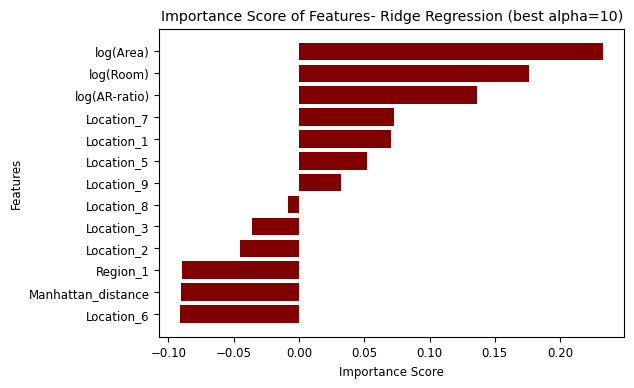

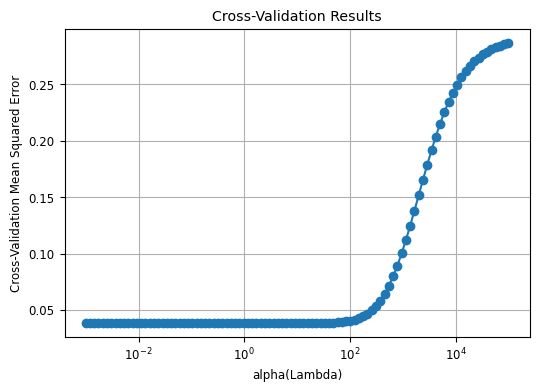

Optimal alpha(Lambda) selected by cross-validation: 10.974987654930567


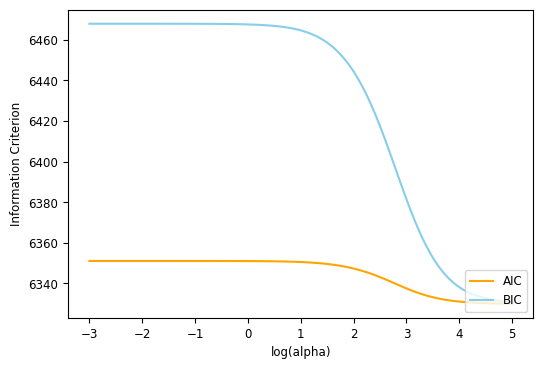

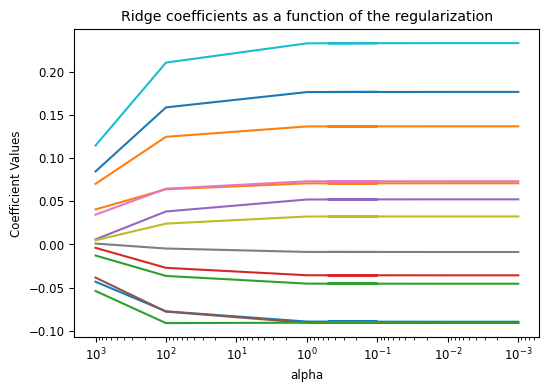

In [60]:
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV

################ model performance: Ridge Regression ################
#specify ridge regression model
model= models[1]
# fit the model
start_time = time()
reg = model.fit(X_train_scaled, y_train)
fit_time = time() - start_time
print(f"Training time: {fit_time:.3f}s")

#cross validation results from ridge regression
ridge_cv= linear_model.RidgeCV(cv=10,alphas=[1e-3, 0.05, 1e-2,0.5,0.2,1e-1,1,10]).fit(X_train_scaled, y_train)
# fit the model
start_time = time()
fit_time = time() - start_time
print(f"Validation time: {fit_time:.3f}s")

print("Chosen alpha: {:.3f}".format(ridge_cv.alpha_))
print("Accuracy on training set: {:.3f}".format(ridge_cv.score(X_train_scaled,y_train)))
print("Accuracy on validation set: {:.3f}".format(ridge_cv.score(X_val_scaled,y_val)))

##################### Feature importance: Ridge Regression #####################
# Plot feature importance
importance =reg.coef_
feature= X_train_scaled.columns.tolist()
# using dictionary comprehension to convert lists to dictionary
label = {feature[i]: importance[i] for i in range(len(feature))}
label= pd.DataFrame.from_dict(label,orient='index').reset_index().rename(columns={'index':'feature', 0:'importance'})
label = label.sort_values(by='importance', ascending=True).set_index('feature')
print(label.sort_values(by='importance', ascending=False))

# creating the bar plot
plt.rcParams['figure.figsize'] = [6, 4]
plt.barh(label.index, label['importance'], color='maroon')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Importance Score of Features- Ridge Regression (best alpha=10)")
plt.show()

####################### Visualise best alpha value for lasso regression ###################

## Selecting alpha using information CV score for the final ridge regression model. 
# Define lambdas space 
lambdas_to_try = 10 ** np.linspace(-3, 5, 100)

# Perform 10-fold cross-validation to select lambda
ridge_cv = RidgeCV(alphas=lambdas_to_try, store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)

# Plot cross-validation results
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)
plt.figure()
plt.semilogx(lambdas_to_try, cv_mse, marker='o', linestyle='-')
plt.xlabel('alpha(Lambda)')
plt.ylabel('Cross-Validation Mean Squared Error')
plt.title('Cross-Validation Results')
plt.grid(True)
plt.show()

# Optimal lambda
optimal_lambda = ridge_cv.alpha_
print("Optimal alpha(Lambda) selected by cross-validation:", optimal_lambda)


## Selecting alpha using information criteria (AIC and BIC) for the final ridge regression model. 
# Best cross-validated lambda
lambda_cv = ridge_cv.alpha_

# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv = Ridge(alpha=lambda_cv)
model_cv.fit(X_train_scaled, y_train)
y_hat_cv = model_cv.predict(X_val_scaled)
ssr_cv = np.sum(np.square(y_val - y_hat_cv))
rsq_ridge_cv = (np.corrcoef(y_val, y_hat_cv))**2

# Use information criteria to select lambda
X_scaled = (X_train_scaled - np.mean(X_train_scaled, axis=0)) / np.std(X_train_scaled, axis=0)  # Standardize the data
aic = []
bic = []

for lambda_value in lambdas_to_try:
    ridge = Ridge(alpha=lambda_value)
    ridge.fit(X_scaled, y_train)
    betas = ridge.coef_
    resid = y_train- np.dot(X_scaled, betas)
    
    # Compute hat-matrix and degrees of freedom
    ld = lambda_value * np.diag(np.std(X_scaled, axis=0) ** 2)
    H = np.dot(np.dot(X_scaled, np.linalg.inv(np.dot(X_scaled.T, X_scaled) + ld)), X_scaled.T)
    df = np.trace(H)
    
    # Compute information criteria
    aic_value = len(X_scaled) * np.log(np.dot(resid.T, resid)) + 2 * df
    bic_value = len(X_scaled) * np.log(np.dot(resid.T, resid)) + 2 * df * np.log(len(X_scaled))
    
    aic.append(aic_value)
    bic.append(bic_value)

# Plot information criteria against log values of lambdas
plt.plot(np.log10(lambdas_to_try), aic, color='orange', linestyle='-', label='AIC')
plt.plot(np.log10(lambdas_to_try), bic, color='skyblue', linestyle='-', label='BIC')
plt.xlabel('log(alpha)')
plt.ylabel('Information Criterion')
plt.legend(loc='lower right')
plt.show()


############## Explore the impact of different alpha values on the coefficients################
# Display Ridge coefficients as a function of the regularization
# visualise optimal alpha value for ridge regression
n_alphas = 2000
alphas = param0['alpha']
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True, solver='auto', random_state=42)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)
    
plt.rcParams['figure.figsize'] = [6, 4]
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("Coefficient Values")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()



##### 7.2 Lasso Regression

Training time: 0.006s
Validation time: 0.000s
Chosen alpha: 0.0010
Number of regressors in the menu:  13
Number of regressors selected by lasso:  11
Regressors removed by lasso:  ['Location_9', 'log(Room)']
Accuracy on training set: 0.875
Accuracy on validation set: 0.823
                    importance
feature                       
log(Area)             0.443683
Location_7            0.036820
Location_1            0.025380
Location_5            0.007277
log(AR-ratio)         0.003898
Location_9            0.000000
log(Room)             0.000000
Location_8           -0.028119
Location_3           -0.060934
Location_2           -0.070559
Manhattan_distance   -0.093148
Region_1             -0.117670
Location_6           -0.132425


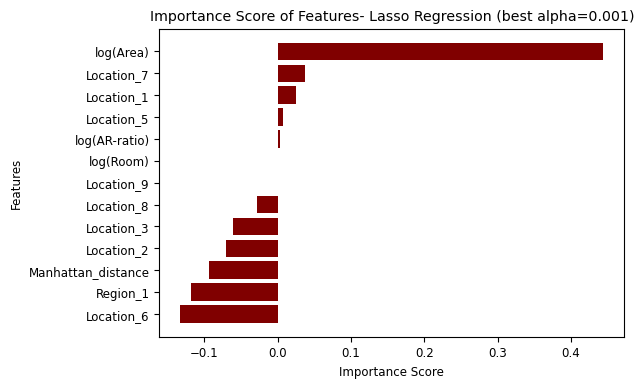

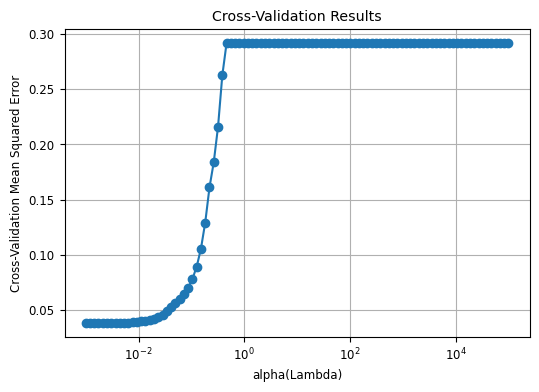

Optimal alpha(Lambda) selected by cross-validation: 0.001


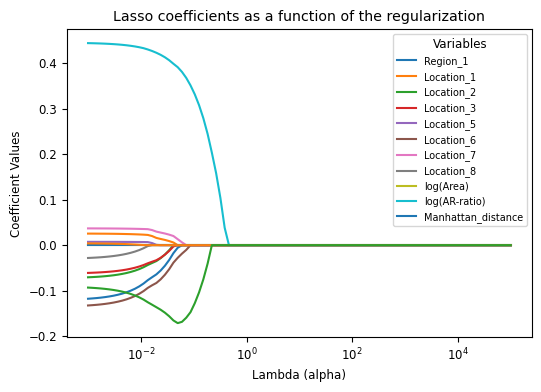

In [61]:
# Lasso Regression with best hyperparameters
from sklearn.linear_model import LassoCV

################## Lasso model performance ########################
# fit the model
start_time = time()
model= linear_model.Lasso(alpha=.001,max_iter=1000000).fit(X_train_scaled,y_train)
fit_time = time() - start_time
print(f"Training time: {fit_time:.3f}s")

#cross validation results from Lasso regression
lasso_cv= linear_model.LassoCV(cv=10,alphas=( 1e-3, 1e-2,0.5,1e-1, 1,10)).fit(X_train_scaled, y_train)
# fit the model
start_time = time()
fit_time = time() - start_time
print(f"Validation time: {fit_time:.3f}s")

print("Chosen alpha: {:.4f}".format(lasso_cv.alpha_))
print("Number of regressors in the menu: ",len(X_train_scaled.columns))
print("Number of regressors selected by lasso: ",sum(lasso_cv.coef_!=0)) #except those non-zero coeff lasso would through away, how much retained
print("Regressors removed by lasso: ", X_train_scaled.columns[lasso_cv.coef_==0].tolist())
print("Accuracy on training set: {:.3f}".format(lasso_cv.score(X_train_scaled,y_train)))
print("Accuracy on validation set: {:.3f}".format(lasso_cv.score(X_val_scaled,y_val)))

################## feature importance ############################
# get feature importance
importance =model.coef_
feature= X_train_scaled.columns.tolist()
# using dictionary comprehension to convert lists to dictionary
label = {feature[i]: importance[i] for i in range(len(feature))}
label= pd.DataFrame.from_dict(label,orient='index').reset_index().rename(columns={'index':'feature', 0:'importance'})
label = label.sort_values(by='importance', ascending=True).set_index('feature')
print(label.sort_values(by='importance', ascending=False))

# creating the bar plot
plt.barh(label.index, label['importance'], color='maroon')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Importance Score of Features- Lasso Regression (best alpha=0.001)")
plt.show()

############## Visualise best alpha value for lasso regression ################

# Lambdas (alpha values) to try
lambdas_to_try = 10 ** np.linspace(-3, 5, 100)

# Perform 10-fold cross-validation to select lambda for Lasso regression
lasso_cv = LassoCV(alphas=lambdas_to_try, cv=10)
lasso_cv.fit(X_train_scaled,y_train)

# Plot cross-validation results
mse_path = np.mean(lasso_cv.mse_path_, axis=1)
plt.figure()
plt.semilogx(lasso_cv.alphas_, mse_path, marker='o', linestyle='-')
plt.xlabel('alpha(Lambda)')
plt.ylabel('Cross-Validation Mean Squared Error')
plt.title('Cross-Validation Results')
plt.grid(True)
plt.show()

# Optimal lambda
optimal_lambda = lasso_cv.alpha_
print("Optimal alpha(Lambda) selected by cross-validation:", optimal_lambda)


############## Explore the impact of different alpha values on the coefficients################
# Best cross-validated lambda
lambda_cv = lasso_cv.alpha_

# Fit final model, get its sum of squared residuals and multiple R-squared
model_cv = Lasso(alpha=lambda_cv, max_iter=5000000)
model_cv.fit(X_train_scaled,y_train)
y_hat_cv = model_cv.predict(X_val_scaled)
ssr_cv = np.sum(np.square(y_val - y_hat_cv))
rsq_lasso_cv = (np.corrcoef(y_val, y_hat_cv)[0, 1])**2

# plot the coefficient values for different alpha (lambda) values.
alphas_to_try = lambdas_to_try
coefs = []
for alpha in alphas_to_try:
    lasso = Lasso(alpha=alpha,fit_intercept=True, random_state=42)
    lasso.fit(X_train_scaled,y_train)
    coefs.append(lasso.coef_)


plt.figure()
plt.semilogx(alphas_to_try, coefs)
plt.xlabel('Lambda (alpha)')
plt.ylabel('Coefficient Values')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(X_train_scaled.columns[model_cv.coef_!=0], title="Variables", prop={"size": 7})
plt.show()

##### 7.3 Comparing Ridge and Lasso regressions 

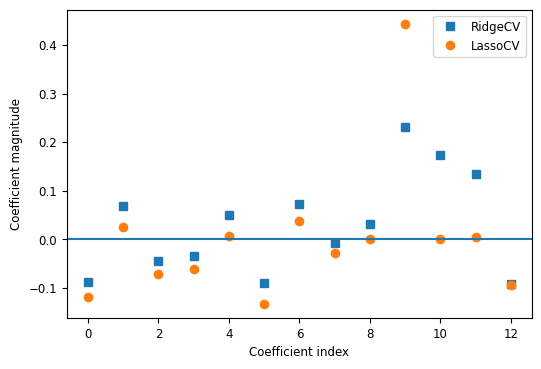

In [62]:
# visualise coefficients for to compare ridge and Lasso models 
plt.plot(ridge_cv.coef_, 's', label="RidgeCV")
plt.plot(lasso_cv.coef_, 'o', label="LassoCV")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.legend()

- Comparatively, both Ridge and Lasso showed improvement on R^2 compared to Linear Regression. Yet, cross validation score from Lasso only improved to a small extend, but with the cost of higher training time. This seems to suggest Ridge Regression being a better choice. 
- Moreover, looking at feature importance, output from Ridge Regression seems easier to interpret, where the most importance feature is `log(Area)`, as expected. This also in favour of the choice of Ridge model. 
- To further validate this choice, I will train on ElasticNet model, which is a combination of both models. By intepreting L1 ratio, one can gain further understanding of the selection between Ridge and Lasso models. 

##### 7.4 ElasticNet Regression 

Training time: 0.002s
Validation time: 0.000s
Chosen l1 ratio: 0.0000
Chosen alpha: 0.010
Number of regressors in the menu:  13
Number of regressors selected by elastic net:  13
Accuracy on training set: 0.875
Accuracy on test set: 0.822
                    importance
feature                       
log(Area)             0.443853
Location_7            0.065824
Location_1            0.061604
Location_5            0.043076
Location_9            0.025758
log(AR-ratio)         0.004270
log(Room)             0.000000
Location_8           -0.012038
Location_3           -0.040312
Location_2           -0.049895
Manhattan_distance   -0.091746
Region_1             -0.094278
Location_6           -0.098396


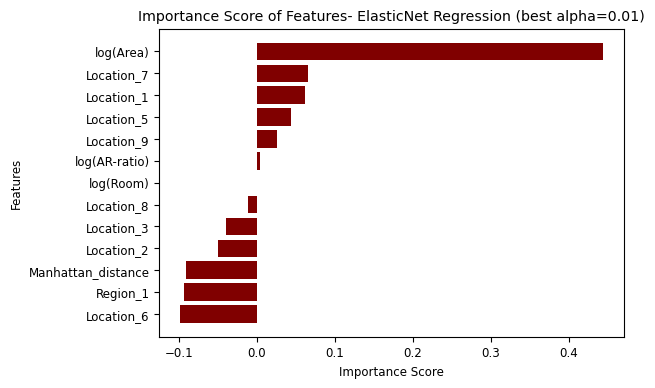

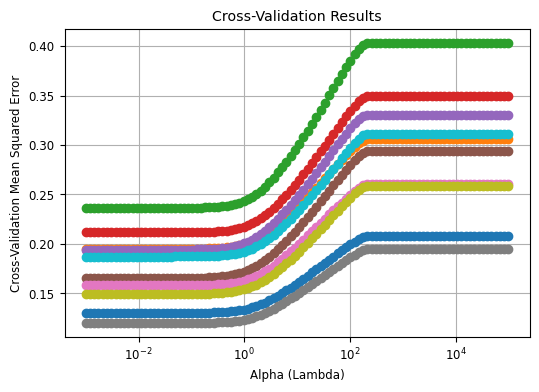

Optimal alpha (Lambda) selected by cross-validation: 0.013530477745798075


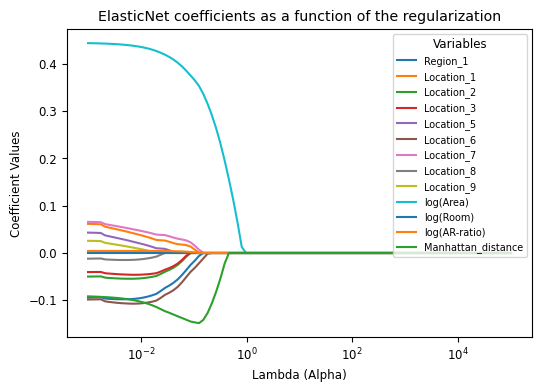

In [63]:
# ElasticNet Regression with best hyperparameters
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error

################## ElasticNet model performance ########################
# fit the model
start_time = time()
model= linear_model.ElasticNet(l1_ratio=0.5,alpha= 0.001,max_iter=1000000).fit(X_train_scaled,y_train)
fit_time = time() - start_time
print(f"Training time: {fit_time:.3f}s")

#cross validation results from ElasticNet regression
elasticnet_cv= linear_model.ElasticNetCV(cv=10,alphas=[1e-3, 1e-2,0.5,0.2,1e-1,1,1e+2, 1e+3],l1_ratio= np.arange(0,1, 0.01),max_iter=1000000).fit(X_train_scaled, y_train)
# fit the model
start_time = time()
fit_time = time() - start_time
print(f"Validation time: {fit_time:.3f}s")

print("Chosen l1 ratio: {:.4f}".format(elasticnet_cv.l1_ratio_))
print("Chosen alpha: {:.3f}".format(elasticnet_cv.alpha_))
print("Number of regressors in the menu: ",len(X_train_scaled.columns))
print("Number of regressors selected by elastic net: ",sum(elasticnet_cv.coef_!=0))
print("Accuracy on training set: {:.3f}".format(elasticnet_cv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(elasticnet_cv.score(X_val_scaled,y_val)))


################## feature importance ############################
# get importance
importance =model.coef_
feature= X_train_scaled.columns.tolist()
# using dictionary comprehension to convert lists to dictionary
label = {feature[i]: importance[i] for i in range(len(feature))}
label= pd.DataFrame.from_dict(label,orient='index').reset_index().rename(columns={'index':'feature', 0:'importance'})
label = label.sort_values(by='importance', ascending=True).set_index('feature')
print(label.sort_values(by='importance', ascending=False))

# creating the bar plot
plt.barh(label.index, label['importance'], color='maroon')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Importance Score of Features- ElasticNet Regression (best alpha=0.01)")
plt.show()

from sklearn.linear_model import ElasticNetCV, ElasticNet
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Lambdas (alpha values) to try
lambdas_to_try = 10 ** np.linspace(-3, 5, 100)
l1_ratio_to_try =np.logspace(-8,8, 100)  # Adjust l1_ratio values to match the length of alphas

# Perform 10-fold cross-validation to select lambda for Lasso regression
elastic_cv = ElasticNetCV(alphas=lambdas_to_try, l1_ratio=l1_ratio_to_try, cv=10,max_iter=1000000)
elastic_cv.fit(X_train_scaled, y_train)

# Plot cross-validation results
mse_path = np.mean(elastic_cv.mse_path_, axis=1)
optimal_alpha = elastic_cv.alpha_

plt.figure()
plt.semilogx(lambdas_to_try, mse_path, marker='o', linestyle='-')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Cross-Validation Mean Squared Error')
plt.title('Cross-Validation Results')
plt.grid(True)
plt.show()

# Optimal lambda
optimal_lambda = elastic_cv.alpha_
print("Optimal alpha (Lambda) selected by cross-validation:", optimal_lambda)

# Best cross-validated lambda and l1_ratio
optimal_alpha = elastic_cv.alpha_
optimal_l1_ratio = elastic_cv.l1_ratio_

# Fit the final model, get its sum of squared residuals, and multiple R-squared
model_cv = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, max_iter=1000000)
model_cv.fit(X_train_scaled, y_train)
y_hat_cv = model_cv.predict(X_val_scaled)
ssr_cv = np.sum(np.square(y_val - y_hat_cv))
rsq_lasso_cv = (np.corrcoef(y_val, y_hat_cv)[0, 1])**2

# Plot the coefficient values for different alpha (lambda) values.
coefs = []
for alpha in lambdas_to_try:
    enet = ElasticNet(alpha=alpha)
    enet.fit(X_train_scaled, y_train)
    coefs.append(enet.coef_)

plt.figure()
plt.semilogx(lambdas_to_try, coefs)
plt.xlabel('Lambda (Alpha)')
plt.ylabel('Coefficient Values')
plt.title('ElasticNet coefficients as a function of the regularization')

plt.legend(X_train_scaled.columns[model_cv.coef_!=0], title="Variables", prop={"size": 7},loc="upper right", )
plt.show()


- ElasticNet showed best l1_ratio = 0, indicated Ridge regression is a better choice. 

**8. Measure the model performance and keep in memory the trained models.**

In [64]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score,max_error

#plug in the best hyperparameters for each model
regressors = [
    LinearRegression(fit_intercept=True),
    Ridge(alpha=10),
    Lasso(alpha=0.001),
    ElasticNet(alpha=0.01, l1_ratio=0.5)
]

for model in regressors:
    start = time()
    model.fit(X_train_scaled, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_val_scaled)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print(f"\tExplained variance: {round(explained_variance_score(y_val, y_pred),4)}")
    print(f"\tMean absolute error: {round(mean_absolute_error(y_val, y_pred),4)}")
    print(f"\tMean Squared error: {round(mean_squared_error(y_val, y_pred, squared= False),4)}")
    print(f"\tR2 score: {round(r2_score(y_val, y_pred),4)}")
    print(f"\tMax error: {round(max_error(y_val, y_pred),4)}")
    print()

LinearRegression()
	Training time: 0.003s
	Prediction time: 0.001s
	Explained variance: -7.136568859851745e+23
	Mean absolute error: 315809136012.6646
	Mean Squared error: 454498472508.3596
	R2 score: -7.136568859851745e+23
	Max error: 1354181996941.6226

Ridge(alpha=10)
	Training time: 0.001s
	Prediction time: 0.001s
	Explained variance: 0.8281
	Mean absolute error: 0.1598
	Mean Squared error: 0.227
	R2 score: 0.822
	Max error: 1.0457

Lasso(alpha=0.001)
	Training time: 0.005s
	Prediction time: 0.001s
	Explained variance: 0.8293
	Mean absolute error: 0.1597
	Mean Squared error: 0.2262
	R2 score: 0.8233
	Max error: 1.0052

ElasticNet(alpha=0.01)
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.8293
	Mean absolute error: 0.16
	Mean Squared error: 0.2262
	R2 score: 0.8232
	Max error: 0.9848



- Taking the above findings together. Linear Regression model showed extremely large variances and it is likely overfitting the pre-processed data. 
- On the other hand, among all regularised regressions, Ridge model showed the highest efficieny (i.e., minimal train time), and have returned relative optimal R^2 and MAE. 

**9. Train several models by repeating the abovementioned procedure**

In [65]:
# Remove the impact of outliers --> Restrict the analysis to samples with price < 2M 
threshold = 2e6  # CUSTOMIZABLE threshold

# discard target values > threshold
y_train_bounded = y_train.loc[y_train < np.log(threshold)]
y_val_bounded = y_val.loc[y_val < np.log(threshold)]

# discard all sample in X_train_enc and X_val_enc with price > 2M
X_train_bounded = X_train.loc[y_train < np.log(threshold), :]
X_val_bounded = X_val.loc[y_val < np.log(threshold), :]


categorical_features = X_train_bounded.select_dtypes(include='category')
numeric_features = X_train_bounded.select_dtypes(include='float64')

# Data preprocessing 
categorical_transformer = Pipeline(
    steps=[
    ('ohe_encoder', OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)),
    ('scaler', StandardScaler())
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

pipeline = ColumnTransformer(
    transformers=[
     ('ohe_encoder', categorical_transformer, categorical_features.columns),
     ('num_imputer', numeric_transformer, numeric_features.columns)
     ], verbose_feature_names_out=True
    )

pipeline

ColumnTransformer(transformers=[('ohe_encoder',
                                 Pipeline(steps=[('ohe_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Region', 'Location'], dtype='object')),
                                ('num_imputer',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['log(Area)', 'log(Room)', 'log(AR-ratio)', 'Manhattan_distance'], dtype='object'))])

In [66]:
# transform the train and validation datasets
X_train_scaled_bounded= pd.DataFrame(pipeline.fit_transform(X_train_bounded))
X_train_scaled_bounded.columns = pipeline.get_feature_names_out()
X_train_scaled_bounded = X_train_scaled_bounded.rename(columns=lambda x: x.split('__')[-1]) #tidy up column names


X_val_scaled_bounded= pd.DataFrame(pipeline.fit_transform(X_val_bounded))
X_val_scaled_bounded.columns = pipeline.get_feature_names_out()
X_val_scaled_bounded = X_val_scaled_bounded.rename(columns=lambda x: x.split('__')[-1]) #tidy up column names


In [67]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score,max_error

models = [
    Ridge(alpha=10),
    Lasso(alpha=0.001),
    ElasticNet(alpha=0.01, l1_ratio=0.5)
]


for model in models:
    start = time()
    model.fit(X_train_scaled_bounded, y_train_bounded)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_val_scaled_bounded)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print(f"\tExplained variance: {round(explained_variance_score(y_val_bounded, y_pred),4)}")
    print(f"\tMean absolute error: {round(mean_absolute_error(y_val_bounded, y_pred),4)}")
    print(f"\tMean Squared error: {round(mean_squared_error(y_val_bounded, y_pred, squared= False),4)}")
    print(f"\tR2 score: {round(r2_score(y_val_bounded, y_pred),4)}")
    print(f"\tMax error: {round(max_error(y_val_bounded, y_pred),4)}")
    print()

Ridge(alpha=10)
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.82
	Mean absolute error: 0.1536
	Mean Squared error: 0.2154
	R2 score: 0.8117
	Max error: 0.9508

Lasso(alpha=0.001)
	Training time: 0.006s
	Prediction time: 0.001s
	Explained variance: 0.8218
	Mean absolute error: 0.1534
	Mean Squared error: 0.2144
	R2 score: 0.8134
	Max error: 0.9068

ElasticNet(alpha=0.01)
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.8212
	Mean absolute error: 0.1539
	Mean Squared error: 0.2147
	R2 score: 0.8128
	Max error: 0.8921



**10. compare their performance and pick the best-performing model (don't forget to compare them models against the baseline model).**

- Removing for outliers does not seem to substantially improve the efficiency and performance of the models. Yet, it has shown decrease in max error. 
- Combining all findings together, it has suggested that Ridge model with removal of extreme outliers should be retained. 


**11. Save the model as a pickle file with its model performance and relevant metadata similar to the baseline model computed in 4️⃣ Create a baseline Model.**

🚨 This model is not production ready.


In [68]:
# Fit Simple linear Regression model using scikit-learn API
reg = Ridge(alpha=10).fit(X_train_scaled_bounded, y_train_bounded)

# Display model
display(reg)

Ridge(alpha=10)

In [69]:
# Generate folder name
MODEL_NAME = "trained_model (Ridge Regression)"
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
FOLDER_NAME = f"{timestamp}_{MODEL_NAME}"
print("• Artifacts will be saved in the folder: ", FOLDER_NAME)


• Artifacts will be saved in the folder:  2023-11-08-22-02-57_trained_model (Ridge Regression)


In [70]:
# save to pre-existing folder in the artifacts directory
ARTIFACTS_DIR = "./artifacts"
if not os.path.exists(os.path.join(ARTIFACTS_DIR, FOLDER_NAME)):
    os.makedirs(os.path.join(ARTIFACTS_DIR, FOLDER_NAME))

# Save model as a pickle file
with open(os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + ".pkl"), "wb") as f:
    pickle.dump(reg, f)

In [71]:
# load model and check whether it is the same as the one saved
with open(os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + ".pkl"), "rb") as f:
    train_model = pickle.load(f)

train_model

Ridge(alpha=10)

In [72]:
# Retrieve the coefficients of the baseline model retrieve using scikit-learn API
sk_coef_ = pd.Series(
    np.concatenate((np.array([train_model.intercept_]), train_model.coef_)),
    index=["const"] + X_train_scaled_bounded.columns.tolist(),
)
display(sk_coef_)

const                 13.112784
Region_1              -0.093240
Location_1             0.067362
Location_2            -0.041837
Location_3            -0.033906
Location_5             0.052973
Location_6            -0.089303
Location_7             0.073962
Location_8            -0.006209
Location_9             0.033621
log(Area)              0.211673
log(Room)              0.159416
log(AR-ratio)          0.116639
Manhattan_distance    -0.077494
dtype: float64

In [73]:
Metadata = f"""
---
library_name: sklearn
tags:
- Amsterdam house pricing prediction
- tabular-regression
license: NA
datasets:
- {DATA_TRAIN_PATH}
- {DATA_VAL_PATH}
model: 
- 'Ridge regression'
metrics:
- 'r-squared'
features:
- {X_train_scaled_bounded.columns.tolist()}
target:
- {y_train_bounded.name}
additional_information: 
- Dataset is bounded to samples with price < 2M
- The Dataset contains only houses from Amsterdam
- IMPORTANT: this model is not production ready
---
"""

# store string as a markdown file
with open(
    os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + "_metadata.md"), "w"
) as f:
    f.write(Metadata)